In [1]:
from IPython.core.display import HTML

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from scipy.integrate import odeint, trapz, simps
from IPython.display import HTML

from scipy.fft import fft, ifft
matplotlib.rcParams.update({'font.size': 14})


# 1.a Pseudospectral method

based on the code in:´

https://www.youtube.com/watch?v=rsdqvrldgHM&list=WL&index=181

To do:
- clean up code SCFT method specialy
    - check the boundary conditions in the calculation of the densities (periodic boundaries have not been very weel implemented up to no1 w) REMEBER TO CHANGE IT IN SCFT ALSO
    
    - try multiplying Xhi * N instead of just putting 15
- experiment with the euler step in the pseudospectral
- put titles and axis laels on graphs and all of that



Calculate the single chain partition function to make sure that propagators are correct. This partition function should be constant across all 's'

# Explicit euler method 

 


In [3]:
# ----------------------
# Global Constants------
# ----------------------
Re = 1.0
# number of points in space 
Nx = 256
# number of beads in the polymer contour
N = 64
# polymer contour
s = np.linspace(0,1,N)
# cutting point of the polymer diving A and B
F = 1/2


In [77]:
def spectral_q(q,t,wx,nx,l):
    # pseudospectral differential equation
    
    # args-> q :array, the propagator to solve
    #        t: vector, represents the polymer contour 
    #       wx: array, the external field
    #       nx: scalar, number of x points
    #       l: scalar, length of the system
    
    # coeffient for the second derivative
    a = ((Re)**2)/6
    # n that indexes the fourier modes*1.j
    n = np.fft.fftfreq(nx)*nx*2*np.pi/l
    ds = t[1]-t[0]
    return np.exp(-1*wx*ds/2.0)* ifft( np.exp(-a*n**2*ds)*fft(np.exp(-wx*ds/2.0)*q) ).real

def spectral_q_dag(q,t,wx,nx,l):
    # pseudospectral differential equation
    
    # args-> q :array, the propagator to solve
    #        t: vector, represents the polymer contour 
    #       wx: array, the external field
    #       nx: scalar, number of x points
    #       l: scalar, length of the system
    
    # coeffient for the second derivative
    a = ((Re)**2)/6
    # n that indexes the fourier modes *1.j
    n = np.fft.fftfreq(nx)*nx*2*np.pi/l
    ds = t[0]-t[1]

    return (np.exp(wx*ds/2.0)* ifft( np.exp(a*n**2*ds)*fft(np.exp(wx*ds/2.0)*q)).real)

# re,x ,s, f ,wa, wb
def calculate_densities(s,nx,f,L, wa, wb):
        # Calculates the densities of given wa and wb
    
    # args -> re: scalar, Re experimental paramaterer
    # nx: scalar, number if spatial postions
    # s: array, position of chains
    # f: scalar, cut off point between A and B parts
    # wa: array, w field for the first half of the copolymer
    # wb: array, w field for the second half of the copolymer
    
    # returs-> phi_a, phi_b arrays representing the densities 
    q = [np.ones(Nx)]
    q_dag = [np.ones(Nx)]
    
    # for q
    w_curr = wa
    for i in range(0,len(s)-1):
        if i==int(len(s)*f)-1:
            w_curr = wb

        q_next = spectral_q(q[i],s,w_curr,nx,L)
        q.append(list(q_next))
        
    q = np.asarray(q)
    
    # Same process for q dagger
    w_curr = wb
    for i in range(0,len(s)-1):
        if i==int(len(s)*f-1):
            w_curr = wa

        q_dag_next = spectral_q_dag(q_dag[i],s,w_curr,nx,L)
        q_dag.append(list(q_dag_next))
    q_dag =  np.asarray(q_dag)
    q_dag = np.flip(q_dag)
    
    return q, q_dag


In [78]:
l=2
N = 10
np.fft.fftfreq(N)*2*np.pi*1.j/l

array([ 0.+0.j        ,  0.+0.31415927j,  0.+0.62831853j,  0.+0.9424778j ,
        0.+1.25663706j, -0.-1.57079633j, -0.-1.25663706j, -0.-0.9424778j ,
       -0.-0.62831853j, -0.-0.31415927j])

## First approximation

In [97]:
# length of the system
L = 2*Re

# spatial discretization 
x = np.linspace(0,Nx, Nx)
x = x*L/Nx

wa = 5*np.cos(2*np.pi*x/L)
wb = -wa

In [98]:
q,q_dag = calculate_densities(s,Nx,F,L, wa, wb)   

Text(0.5, 0, '$s$')

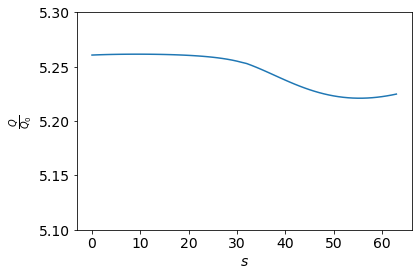

In [99]:
Q_Q0 = trapz(q*q_dag, x,axis=1)
plt.ylim(5.1,5.3)
plt.plot(Q_Q0)

plt.ylabel(r'$\frac{Q}{Q_0}$')
plt.xlabel(r'$s$')


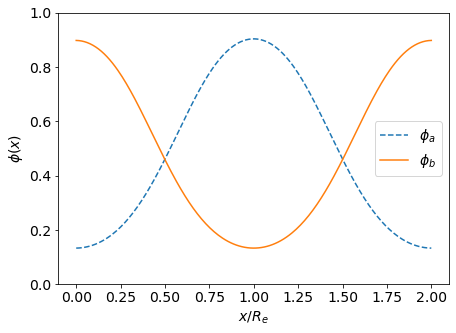

In [100]:
prod_q = q*q_dag
phi_a = (L/np.max(Q_Q0))*trapz(prod_q[:int(len(s)*F)], s[:int(len(s)*F)],axis=0)
phi_b = (L/np.max(Q_Q0))*trapz(prod_q[int(len(s)*F):], s[int(len(s)*F):],axis=0)

plt.figure(figsize=(7,5))
plt.plot(x, phi_a, label='$\phi_a$',linestyle='dashed')
plt.plot(x, phi_b,label='$\phi_b$')
plt.ylim(0,1)
plt.xlabel(r'$x/R_e$')
plt.ylabel(r'$\phi(x)$')
plt.legend()



## SCFT

First Iteration of scft

In [115]:
def SCFT(X, L, Chi_N, Alpha):
    # big method to run SCFT as a functions of the arguments. Includes piccard iteration and pseudospectral parts
    
    # parameter definitions and initial values
    target_deviation_1 = 10**(-3)
    target_deviation_2 = 10**(-3)

    wa = 5*np.cos(2*np.pi*X/L)
    wb = -wa

    consistency_1 = []
    consistency_2 = []

    phi_a_list = []
    phi_b_list = []

    deviation_1 = []
    deviation_2 = []

    Q0_list = []
    w_minus_list = []
    w_plus_list =  []
    
    # calculate the first approximation for the densities
    q,q_dag = calculate_densities(s,Nx,F,L, wa, wb)   
    Q_Q0 = trapz(q*q_dag, X ,axis=1)
    Q0_list.append(Q_Q0)
    prod_q = q*q_dag
    phi_a = (L/np.max(Q_Q0))*trapz(prod_q[:int(len(s)*F)], s[:int(len(s)*F)],axis=0)
    phi_b = (L/np.max(Q_Q0))*trapz(prod_q[int(len(s)*F):], s[int(len(s)*F):],axis=0)

    # PICCARD iteratrion
    # starting point 
    w_minus_old = wa - wb
    w_plus_old = wa + wb

    phi_a_old = phi_a.copy()
    phi_b_old = phi_b.copy()
    
    stop_loop = False

    i = 0
    while(stop_loop==False):
        # update the omegas
        w_minus = Alpha*( Chi_N*( phi_b_old - phi_a_old ) - w_minus_old ) + w_minus_old
        w_plus = Alpha*( Chi_N*( phi_b_old + phi_a_old ) - 1 ) + w_plus_old

        # calculate the new fields
        wa_new = 0.5*(w_minus + w_plus)
        wb_new = - 0.5*(w_minus - w_plus)

        # calculate the new propagators and densities
        # (s,Nx,F,L, wa, wb) 
        q, q_dag = calculate_densities(s,Nx,F,L,wa_new, wb_new)
        prod_q = q*q_dag

        Q_Q0 = trapz(prod_q, X,axis=1)

        phi_a_new = trapz(prod_q[:int(len(s)*F)], s[:int(len(s)*F)],axis=0)*(L/np.max(Q_Q0))
        phi_b_new = trapz(prod_q[int(len(s)*F):], s[int(len(s)*F):],axis=0)*(L/np.max(Q_Q0))

        # check that restrictions hold
        # first condition right hand side
        rhs_1 = Chi_N*(phi_a_new - phi_b_new)
        rhs_2 = phi_a_new + phi_b_new

        dev_1 = np.abs(w_minus + rhs_1)
        dev_2 = np.abs(1 - rhs_2)

        # save quantities of interest
        consistency_1.append(list(rhs_1))
        consistency_2.append(list(rhs_2))

        phi_a_list.append(list(phi_a_new))
        phi_b_list.append(list(phi_b_new))

        deviation_1.append(list((dev_1)))
        deviation_2.append(list(dev_2))

        Q0_list.append(list(Q_Q0))

        w_minus_list.append(list(w_minus))
        w_plus_list.append(list(w_plus))

        # update values for the next iteration
        w_minus_old = wa_new - wb_new
        w_plus_old = wa_new + wb_new
        #w_minus_old = w_minus.copy()
        #w_plus_old = w_plus.copy()

        phi_a_old = phi_a_new.copy()
        phi_b_old = phi_b_new.copy()

        # check whether the stop condition holds
        if((max(dev_1)< target_deviation_1) and (max(dev_2)< target_deviation_2)):
            # by comparing the maximum of dev_1 we make sure that the condition holds for every x
            stop_loop = True
        # add this to show something while the loop runs
        i+=1  
        if(i%200==0):
            print("elapsed iterations: ", i)
            print("current max deviations:", (max(dev_1), max(dev_2)))
            
    return phi_a_list, phi_b_list, Q0_list ,w_minus_list, w_plus_list, deviation_1, deviation_2

In [116]:
def calculate_free_energy(X, wa_f, wb_f,phia_f, phib_f,q0):
    # calculate free energy
    integral_term = - wa_f*np.asarray(phia_f) - wb_f*np.asarray(phib_f)\
                    + chi_n*np.asarray(phia_f)*np.asarray(phib_f)

    delta_f = -1*np.log((1/L)*np.asarray(max(q0))) + (1/L) * trapz(integral_term, X,axis=0)
    
    return delta_f

In [117]:
L = 2*Re
chi_n = 15
alpha = 0.1


In [118]:
phi_a_list, phi_b_list, Q0_list ,w_minus_list, w_plus_list, deviation_1, deviation_2 = \
                    SCFT(x,L, chi_n, alpha)


elapsed iterations:  200
current max deviations: (0.0010932645524945883, 0.01981227564603838)
elapsed iterations:  400
current max deviations: (1.562412985034456e-05, 0.01953090835662774)
elapsed iterations:  600
current max deviations: (0.022532353625573265, 0.0222544417375663)
elapsed iterations:  800
current max deviations: (0.2502204433096846, 0.8128723226432333)
elapsed iterations:  1000
current max deviations: (0.027514295584653237, 0.8530570806521399)
elapsed iterations:  1200
current max deviations: (0.01295593760795466, 0.869925612410587)
elapsed iterations:  1400
current max deviations: (0.00805154451825163, 0.8797554728532662)
elapsed iterations:  1600
current max deviations: (0.005669978258375785, 0.8865889439189565)
elapsed iterations:  1800
current max deviations: (0.004295631196255645, 0.8917691066696014)
elapsed iterations:  2000
current max deviations: (0.003414950142289097, 0.8958965782313381)
elapsed iterations:  2200
current max deviations: (0.0028090135940017635, 0

KeyboardInterrupt: 

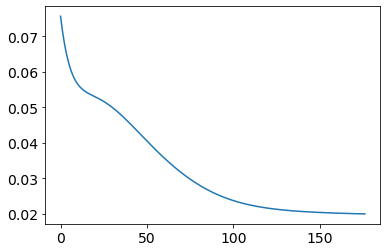

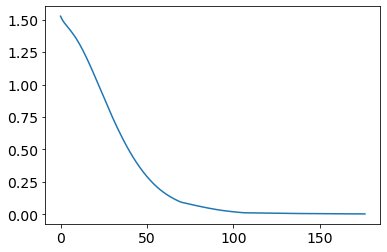

In [119]:
#np.shape(deviation_2)
max_d = [max(x) for x in deviation_2]
plt.figure()
plt.plot(max_d)

max_d = [max(x) for x in deviation_1]
plt.figure()
plt.plot(max_d)


Text(0.5, 0, '$x/R_e$')

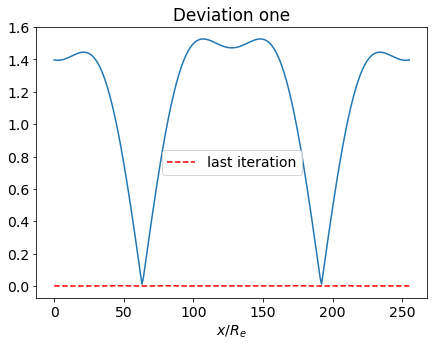

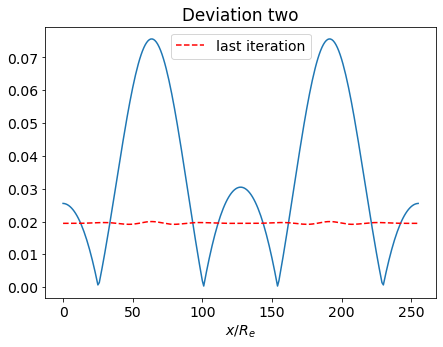

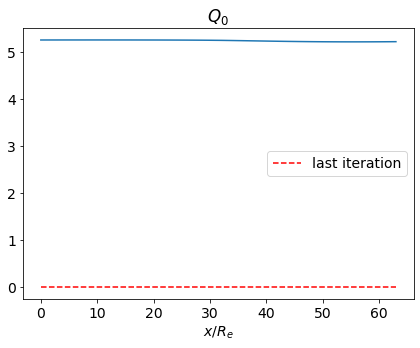

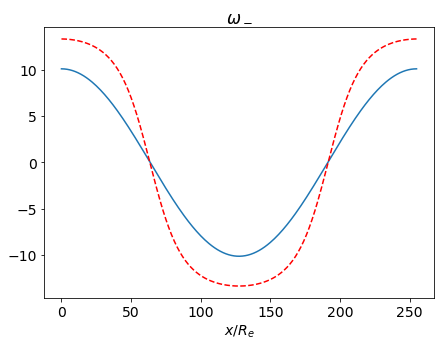

In [112]:
plt.figure(figsize=(7,5))
plt.title("Deviation one")
plt.plot(deviation_1[0])
plt.plot(deviation_1[-1], linestyle='dashed' ,color='r',label='last iteration')
plt.xlabel(r'$x/R_e$')
plt.legend()

plt.figure(figsize=(7,5))
plt.title("Deviation two")
plt.plot(deviation_2[-0])
plt.plot(deviation_2[-1], linestyle='dashed' ,color='r',label='last iteration')
plt.xlabel(r'$x/R_e$')
plt.legend()

plt.figure(figsize=(7,5))
plt.title('$Q_0$')
plt.plot(Q0_list[0])
plt.plot(Q0_list[-1], linestyle='dashed' ,color='r',label='last iteration')
plt.xlabel(r'$x/R_e$')
plt.legend()

plt.figure(figsize=(7,5))
plt.title('$\omega_-$')
plt.plot(w_minus_list[0])
plt.plot(w_minus_list[-1], linestyle='dashed' ,color='r',label='last iteration')
plt.xlabel(r'$x/R_e$')

### Free Energy calculation
Perform SCFT for several values of L

In [ ]:
chi_n = 15
alpha = 0.1
L_list = np.linspace(1.3*Re, 2*Re, 5)
delta_f_list = []

for l in (L_list):
    x = np.linspace(0,Nx, Nx)
    x = x*l/Nx
    
    phi_a_list, phi_b_list, Q0_list ,w_minus_list, w_plus_list, deviation_1, deviation_2 = \
                                    SCFT(x,l, chi_n, alpha)
    # get free energy
    waf = 0.5*(np.asarray(w_plus_list[-1]) + np.asarray(w_minus_list[-1]))
    wbf = 0.5*(np.asarray(w_plus_list[-1]) - np.asarray(w_minus_list[-1]))

    delta_f = calculate_free_energy(x, waf, wbf,phi_a_list[-1], phi_b_list[-1],Q0_list[-1])
    delta_f_list.append(delta_f)

In [ ]:
plt.plot(L_list, delta_f_list)
plt.ylabel(r'$\Delta F / k_bT$')
plt.xlabel(r'$L$')

print("minimum L", L_list[np.argmin(delta_f_list)])